In [1]:
import tensorflow as tf
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
import os

# Dataset paths
base_dir = r"C:\Users\shash\Desktop\Execution_oral"
train_dir = os.path.join(base_dir, 'train')
val_dir = os.path.join(base_dir, 'val')
test_dir = os.path.join(base_dir, 'test')

# Class names for reference
class_names = ['Normal', 'OSCC']
print("Dataset Paths Set!")


C:\Users\shash\anaconda3\lib\site-packages\pandas\core\computation\expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.8.3' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
C:\Users\shash\anaconda3\lib\site-packages\pandas\core\arrays\masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


Dataset Paths Set!


In [2]:
# ImageDataGenerator for training, validation, and testing
train_datagen = ImageDataGenerator(
    rescale=1.0/255.0,        # Normalize pixel values
    rotation_range=20,        # Randomly rotate images
    width_shift_range=0.2,    # Shift horizontally
    height_shift_range=0.2,   # Shift vertically
    shear_range=0.2,          # Shear transformation
    zoom_range=0.2,           # Random zoom
    horizontal_flip=True,     # Flip horizontally
    fill_mode="nearest"       # Fill mode for transformations
)

val_datagen = ImageDataGenerator(rescale=1.0/255.0)  # Only normalization
test_datagen = ImageDataGenerator(rescale=1.0/255.0) # Only normalization

# Load images from directories
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(299, 299),   # Input size for InceptionV3
    batch_size=32,
    class_mode='binary',      # Assuming binary classification (Normal/OSCC)
    shuffle=True
)

val_generator = val_datagen.flow_from_directory(
    val_dir,
    target_size=(299, 299),
    batch_size=32,
    class_mode='binary'
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(299, 299),
    batch_size=32,
    class_mode='binary',
    shuffle=False
)

print("Data Generators Created!")


Found 4946 images belonging to 2 classes.
Found 120 images belonging to 2 classes.
Found 126 images belonging to 2 classes.
Data Generators Created!


In [3]:
# Load the InceptionV3 model
base_model = InceptionV3(
    include_top=False,        # Exclude default top layers
    weights="imagenet",       # Pretrained on ImageNet
    input_shape=(299, 299, 3) # Image input shape
)

# Add custom layers
x = base_model.output
x = GlobalAveragePooling2D()(x)          # Global average pooling
x = Dense(256, activation='relu')(x)    # Fully connected layer
x = tf.keras.layers.Dropout(0.5)(x)     # Dropout for regularization
predictions = Dense(1, activation='sigmoid')(x)  # Output layer (binary)

# Define the complete model
model = Model(inputs=base_model.input, outputs=predictions)

# Freeze base model layers
for layer in base_model.layers:
    layer.trainable = False

# Compile the model
model.compile(
    optimizer=Adam(learning_rate=0.001), 
    loss='binary_crossentropy', 
    metrics=['accuracy']
)

print(model.summary())


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 299, 299, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 149, 149, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 149, 149, 32  96         ['conv2d[0][0]']                 
 alization)                     )                                                             

In [4]:
# Train the model
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // train_generator.batch_size,
    validation_data=val_generator,
    validation_steps=val_generator.samples // val_generator.batch_size,
    epochs=10
)

print("Initial Training Complete!")


Epoch 1/10
154/154 [==============================] - 399s 3s/step - loss: 0.6009 - accuracy: 0.6878 - val_loss: 0.4723 - val_accuracy: 0.7812
Epoch 2/10
154/154 [==============================] - 402s 3s/step - loss: 0.5141 - accuracy: 0.7468 - val_loss: 0.4814 - val_accuracy: 0.7292
Epoch 3/10
154/154 [==============================] - 413s 3s/step - loss: 0.4955 - accuracy: 0.7635 - val_loss: 0.4425 - val_accuracy: 0.7917
Epoch 4/10
154/154 [==============================] - 391s 3s/step - loss: 0.4765 - accuracy: 0.7798 - val_loss: 0.4267 - val_accuracy: 0.7812
Epoch 5/10
154/154 [==============================] - 388s 3s/step - loss: 0.4705 - accuracy: 0.7796 - val_loss: 0.3678 - val_accuracy: 0.8125
Epoch 6/10
154/154 [==============================] - 387s 3s/step - loss: 0.4545 - accuracy: 0.7857 - val_loss: 0.3817 - val_accuracy: 0.8333
Epoch 7/10
154/154 [==============================] - 382s 2s/step - loss: 0.4478 - accuracy: 0.7904 - val_loss: 0.4362 - val_accuracy: 0.8021

In [5]:
# Unfreeze some layers of the base model
for layer in base_model.layers[-50:]:  # Unfreeze the last 50 layers
    layer.trainable = True

# Compile the model with a lower learning rate for fine-tuning
model.compile(
    optimizer=Adam(learning_rate=0.0001), 
    loss='binary_crossentropy', 
    metrics=['accuracy']
)

# Fine-tune the model
history_fine_tuning = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // train_generator.batch_size,
    validation_data=val_generator,
    validation_steps=val_generator.samples // val_generator.batch_size,
    epochs=5
)

print("Fine-Tuning Complete!")


Epoch 1/5
154/154 [==============================] - 507s 3s/step - loss: 0.4011 - accuracy: 0.8183 - val_loss: 0.3127 - val_accuracy: 0.8333
Epoch 2/5
154/154 [==============================] - 529s 3s/step - loss: 0.2643 - accuracy: 0.8928 - val_loss: 0.5185 - val_accuracy: 0.8333
Epoch 3/5
154/154 [==============================] - 540s 4s/step - loss: 0.1950 - accuracy: 0.9249 - val_loss: 0.6049 - val_accuracy: 0.8229
Epoch 4/5
154/154 [==============================] - 542s 4s/step - loss: 0.1666 - accuracy: 0.9369 - val_loss: 0.7016 - val_accuracy: 0.8542
Epoch 5/5
154/154 [==============================] - 531s 3s/step - loss: 0.1506 - accuracy: 0.9461 - val_loss: 0.5404 - val_accuracy: 0.8542
Fine-Tuning Complete!


In [6]:
# Evaluate the model on test data
test_loss, test_accuracy = model.evaluate(test_generator)
print(f"Test Accuracy: {test_accuracy*100:.2f}%")

# Save the model
model.save("inceptionv3_oscc_model.h5")
print("Model Saved!")


4/4 [==============================] - 11s 2s/step - loss: 0.5130 - accuracy: 0.8730
Test Accuracy: 87.30%
Model Saved!


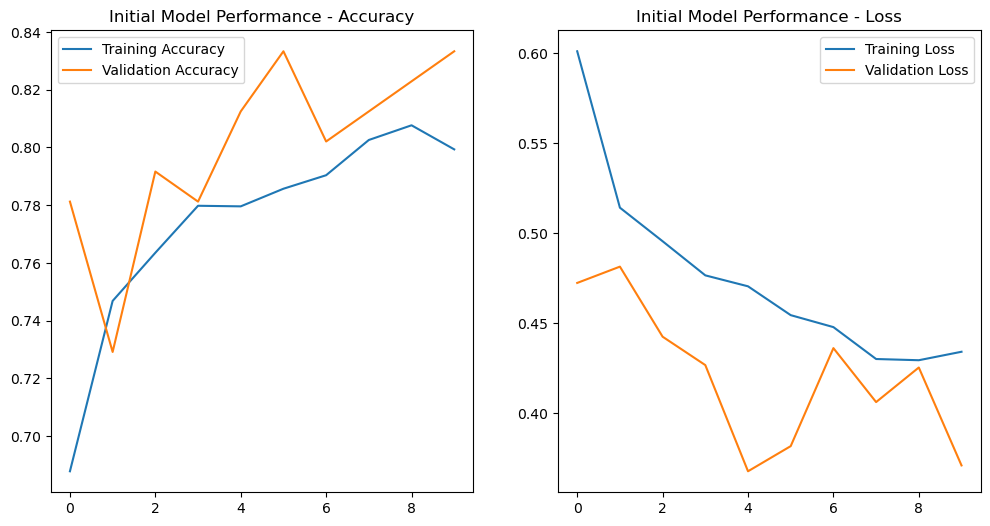

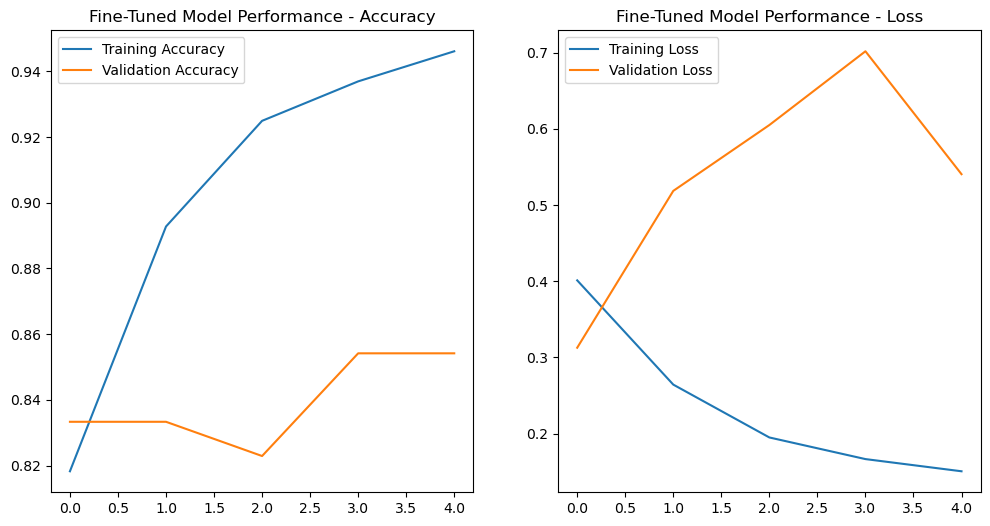

In [9]:
import matplotlib.pyplot as plt

# Function to plot training and validation metrics
def plot_metrics(history, fine_tuned=False):
    epochs_range = range(len(history.history['accuracy']))
    title = "Fine-Tuned Model Performance" if fine_tuned else "Initial Model Performance"

    # Plot accuracy
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, history.history['accuracy'], label='Training Accuracy')
    plt.plot(epochs_range, history.history['val_accuracy'], label='Validation Accuracy')
    plt.legend()
    plt.title(f"{title} - Accuracy")

    # Plot loss
    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, history.history['loss'], label='Training Loss')
    plt.plot(epochs_range, history.history['val_loss'], label='Validation Loss')
    plt.legend()
    plt.title(f"{title} - Loss")

    plt.show()

# Plot metrics for initial training
plot_metrics(history)

# If you've fine-tuned the model, plot metrics for fine-tuning as well
# Uncomment the next line if `history_fine_tuning` exists
plot_metrics(history_fine_tuning, fine_tuned=True)


4/4 [==============================] - 11s 2s/step
Classification Report:
              precision    recall  f1-score   support

      Normal       0.80      0.65      0.71        31
        OSCC       0.89      0.95      0.92        95

    accuracy                           0.87       126
   macro avg       0.85      0.80      0.82       126
weighted avg       0.87      0.87      0.87       126



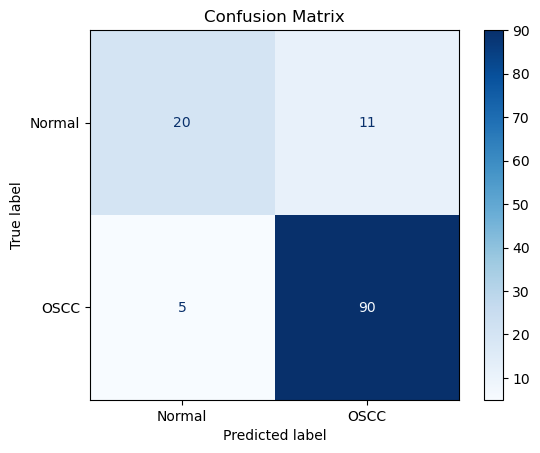

In [10]:
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

# Generate predictions
test_generator.reset()
predictions = model.predict(test_generator, steps=test_generator.samples // test_generator.batch_size + 1)
predicted_classes = (predictions > 0.5).astype(int).reshape(-1)  # Binary classification threshold at 0.5

# Get true labels
true_classes = test_generator.classes
class_labels = list(test_generator.class_indices.keys())

# Classification report
print("Classification Report:")
print(classification_report(true_classes, predicted_classes, target_names=class_labels))

# Confusion Matrix
cm = confusion_matrix(true_classes, predicted_classes)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_labels)
disp.plot(cmap='Blues')
plt.title("Confusion Matrix")
plt.show()


In [19]:
model.save(r"C:\Users\shash\Desktop\Execution_oral\inceptionv3_oscc_model.h5")
print("Model saved successfully!")


Model saved successfully!


In [21]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.inception_v3 import preprocess_input

def predict_and_display(image_path, model, class_labels):
    """
    Function to predict and display the class of an image.
    
    Parameters:
    - image_path (str): Path to the input image.
    - model (tf.keras.Model): Trained Keras model for classification.
    - class_labels (list): List of class labels.
    """
    # Load and preprocess the image
    img = image.load_img(image_path, target_size=(224, 224))
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array = preprocess_input(img_array)
    
    # Perform prediction
    predictions = model.predict(img_array)
    predicted_class = np.argmax(predictions)
    confidence = predictions[0][predicted_class]

    # Display the image and prediction
    plt.imshow(img)
    plt.title(f"Predicted: {class_labels[predicted_class]} ({confidence * 100:.2f}%)")
    plt.axis('off')
    plt.show()
class_labels = ['Normal', 'OSCC']


1/1 [==============================] - 2s 2s/step


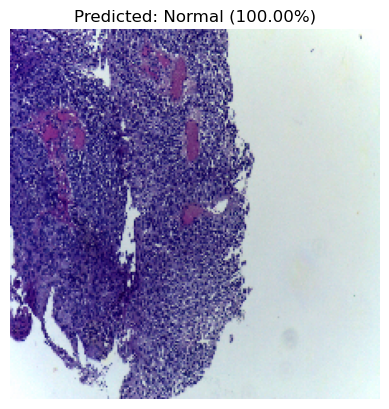

In [24]:
# Specify the test image path
test_image_path = r"C:\Users\shash\Desktop\Execution_oral\test\OSCC\OSCC_100x_113.jpg"

# Predict and display the result
predict_and_display(test_image_path, model, class_labels)
